# Proposed CNN Architecture for Steganalysis by Bayu Aditya T.

# Libraries & Environment

In [ ]:
from scipy import misc, ndimage, signal
from sklearn.model_selection  import train_test_split
import numpy
import numpy as np
import random
import ntpath
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras import optimizers
from keras import regularizers
import tensorflow as tf
import cv2
from keras import backend as K
from time import time
import time as tm
import datetime
from operator import itemgetter
import glob
from skimage.util.shape import view_as_blocks
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc

In [ ]:
!nvidia-smi
#!kill PIDnumber

Sun Nov 19 04:49:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Check GPU

print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

if tf.test.gpu_device_name():
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU found')
else:
    print("No GPU found")

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU found


# Collecting requirement

In [ ]:
!gdown 1Jv7ntjsflNWFvJKDzy49M60ah9Lli26y
!gdown 1enP48jLNIM2V52YczZMAbtxFjAfLpeLs

Downloading...
From: https://drive.google.com/uc?id=1Jv7ntjsflNWFvJKDzy49M60ah9Lli26y
To: /content/0.4.zip
100% 442M/442M [00:05<00:00, 74.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1enP48jLNIM2V52YczZMAbtxFjAfLpeLs
To: /content/SRM_Kernels1.npy
100% 3.13k/3.13k [00:00<00:00, 14.2MB/s]


In [ ]:
!gdown 1Jv7ntjsflNWFvJKDzy49M60ah9Lli26y
!gdown 1enP48jLNIM2V52YczZMAbtxFjAfLpeLs
!mkdir train
!unzip '/content/0.4.zip' -d train
!gdown 13eS-WUYKp0c1lSztdPrx2WF1LvivpzzK
!unzip '/content/data_cover.zip' -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/0.4/5500_stego.pgm  
  inflating: train/0.4/5501_stego.pgm  
  inflating: train/0.4/5502_stego.pgm  
  inflating: train/0.4/5503_stego.pgm  
  inflating: train/0.4/5504_stego.pgm  
  inflating: train/0.4/5505_stego.pgm  
  inflating: train/0.4/5506_stego.pgm  
  inflating: train/0.4/5507_stego.pgm  
  inflating: train/0.4/5508_stego.pgm  
  inflating: train/0.4/5509_stego.pgm  
  inflating: train/0.4/550_stego.pgm  
  inflating: train/0.4/5510_stego.pgm  
  inflating: train/0.4/5511_stego.pgm  
  inflating: train/0.4/5512_stego.pgm  
  inflating: train/0.4/5513_stego.pgm  
  inflating: train/0.4/5514_stego.pgm  
  inflating: train/0.4/5515_stego.pgm  
  inflating: train/0.4/5516_stego.pgm  
  inflating: train/0.4/5517_stego.pgm  
  inflating: train/0.4/5518_stego.pgm  
  inflating: train/0.4/5519_stego.pgm  
  inflating: train/0.4/551_stego.pgm  
  inflating: train/0.4/5520_stego.pgm  
  inflating: train/0.4/5521_ste

In [ ]:
!gdown 13eS-WUYKp0c1lSztdPrx2WF1LvivpzzK
!unzip '/content/data_cover.zip' -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/BOSSbase_1.01 in 256 x 256 size/5499.pgm  
  inflating: train/BOSSbase_1.01 in 256 x 256 size/55.pgm  
  inflating: train/BOSSbase_1.01 in 256 x 256 size/550.pgm  
  inflating: train/BOSSbase_1.01 in 256 x 256 size/5500.pgm  
  inflating: train/BOSSbase_1.01 in 256 x 256 size/5501.pgm  
  inflating: train/BOSSbase_1.01 in 256 x 256 size/5502.pgm  
  inflating: train/BOSSbase_1.01 in 256 x 256 size/5503.pgm  
  inflating: train/BOSSbase_1.01 in 256 x 256 size/5504.pgm  
  inflating: train/BOSSbase_1.01 in 256 x 256 size/5505.pgm  
  inflating: train/BOSSbase_1.01 in 256 x 256 size/5506.pgm  
  inflating: train/BOSSbase_1.01 in 256 x 256 size/5507.pgm  
  inflating: train/BOSSbase_1.01 in 256 x 256 size/5508.pgm  
  inflating: train/BOSSbase_1.01 in 256 x 256 size/5509.pgm  
  inflating: train/BOSSbase_1.01 in 256 x 256 size/551.pgm  
  inflating: train/BOSSbase_1.01 in 256 x 256 size/5510.pgm  
  inflating: train/BOSS

# Implementation preparation

## 30 SRM filters for preprocessing and the activation function

In [ ]:
################################################## 30 SRM FILTERS
srm_weights = np.load('SRM_Kernels1.npy')
biasSRM=numpy.ones(30)
print (srm_weights.shape)
################################################## TLU ACTIVATION FUNCTION
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3
##################################################

(5, 5, 1, 30)


## Proposed architecture

In [ ]:
@tf.keras.utils.register_keras_serializable()
class MixPooling2D(tf.keras.layers.Layer):
    def __init__(self, pool_size=(2, 2), strides=None, padding='valid', **kwargs):
        super(MixPooling2D, self).__init__(**kwargs)
        self.max_pooling = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides, padding=padding)
        self.avg_pooling = tf.keras.layers.AveragePooling2D(pool_size=pool_size, strides=strides, padding=padding)

    def call(self, inputs, **kwargs):
        max_pooled = self.max_pooling(inputs)
        avg_pooled = self.avg_pooling(inputs)
        mixed = tf.concat([max_pooled, avg_pooled], axis=-1)
        return mixed

    def get_config(self):
        config = super(MixPooling2D, self).get_config()
        config.update({
            'pool_size': self.max_pooling.pool_size,
            'strides': self.max_pooling.strides,
            'padding': self.max_pooling.padding,
        })
        return config


def Proposed_Net():
    tf.keras.backend.clear_session()
    #Inputs
    inputs = tf.keras.Input(shape=(256,256,1), name="input_1")
    #Layer 1
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), padding='same', trainable=False, activation=Tanh3, use_bias=True)(inputs)
    layers1 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 2
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers1)
    layers = tf.keras.layers.SeparableConv2D(30,(3,3), padding='same', activation="leaky_relu",depth_multiplier=3)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 3
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers)
    layers = tf.keras.layers.SeparableConv2D(30,(3,3), padding='same', activation="leaky_relu",depth_multiplier=3)(layers)
    layers2 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    skip1 =   tf.keras.layers.Add()([layers1, layers2])
    #Layer 4
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="leaky_relu", padding='same', kernel_initializer='glorot_normal')(skip1)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 11
    layers = MixPooling2D((5,5), strides= (2,2))(layers)
    #Layer 5
    layers = tf.keras.layers.Conv2D(32, (3,3), strides=(1,1), activation="leaky_relu", padding='same', kernel_initializer='glorot_normal')(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 6
    layers = MixPooling2D((5,5), strides= (2,2))(layers)
    #Layer 7
    layers = tf.keras.layers.Conv2D(64, (3,3), strides=(1,1), activation="leaky_relu", padding='same', kernel_initializer='glorot_normal')(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 11
    layers = MixPooling2D((5,5), strides= (2,2))(layers)
    #Layer 12
    layers = tf.keras.layers.Conv2D(64, (3,3), strides=(1,1), activation="leaky_relu", padding='same', kernel_initializer='glorot_normal')(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 13
    layers = MixPooling2D((2,2), strides= (2,2))(layers)
    #Layer 14
    layers = tf.keras.layers.Conv2D(2, (3,3), strides=(1,1), activation="leaky_relu", padding='same', kernel_initializer='glorot_normal')(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 18
    layers = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")(layers)
    #Layer 19
    predictions = tf.keras.layers.Softmax(axis=1)(layers)
    #Model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    #Optimizer
    optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    print ("Model SIGuard-Net Generated")
    #Model compilation
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


## Creating Paths

In [ ]:
# Membuat directory untuk menyimpan berbagai kebutuhan hasil implementasi

path_log_base = './logs'
path_img_base = './images'
if not os.path.exists(path_log_base):
    os.makedirs(path_log_base)
if not os.path.exists(path_img_base):
    os.makedirs(path_img_base)

## Defining different functions to work with the architecture

In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    # Menyipkan directory dan file untuk menyimpan checkpoint tiap epochs.
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_accuracy:.4f}.keras"

    # Mendefinisikan callback.
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()

    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)

    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    print("Starting the training...")
    history=model.fit(X_train, y_train, epochs=epochs,
                      callbacks=[tensorboard,checkpoint],
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=2)

    metrics = model.evaluate(X_test, y_test, verbose=0)

    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)

    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [ ]:
# Menjalankan looping model.evaluate untuk tiap model of epoch dengan target dataset Testing, sehingga ditemukan epoch dengan model terbaik.

def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= []
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            tf.keras.utils.get_custom_objects().update({'Tanh3': Tanh3})
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename)
            loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)
            LossTest.append(BandLossTest)

            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename

    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [ ]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    # Sorting mencari model per epoch terbaik untuk testing
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% total epochs
        index, value = numbers_sort[i]
        print("Test Accuracy {}, epoch:{}\n".format(value, index+1))

    print("")

    # Sorting mencari model per epoch terbaik untuk training
    numbers=history.history['accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% total epochs
        index, value = numbers_sort[i]
        print("Train Accuracy {}, epoch:{}\n".format(value, index+1))

    print("")

    # Sorting mencari model per epoch terbaik untuk validation
    numbers=history.history['val_accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% total epochs
        index, value = numbers_sort[i]
        print("Validation Accuracy {}, epoch:{}\n".format(value, index+1))

    # Plotting akurasi dan loss per epoch untuk training, validation dan testing
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_accuracy'])],axis=0))
        # plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('Accuracy Vs Epoch')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        plt.savefig(path_img_base+'/Accuracy_SIGuard_Net_'+model_Name+'.eps', format='eps')
        plt.savefig(path_img_base+'/Accuracy_SIGuard_Net_'+model_Name+'.svg', format='svg')
        plt.savefig(path_img_base+'/Accuracy_SIGuard_Net_'+model_Name+'.pdf', format='pdf')
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        # plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        plt.savefig(path_img_base+'/Loss_SIGuard_Net_'+model_Name+'.eps', format='eps')
        plt.savefig(path_img_base+'/Loss_SIGuard_Net_'+model_Name+'.svg', format='svg')
        plt.savefig(path_img_base+'/Loss_SIGuard_Net_'+model_Name+'.pdf', format='pdf')
        plt.show()

# Training

## Loading BOSSbase 1.01 dataset for S-UNIWARD 0.4bpp

In [ ]:
# Untuk mengolah dataset gambar agar bisa dipelajari oleh model.
n=256

# Fungsi mengubah gambar menjadi numpy.
def load_images(path_pattern):
    files=glob.glob(path_pattern)
    X=[]
    for f in sorted(files):
        I = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        patches = view_as_blocks(I, (n, n))
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                X.append( [ patches[i,j] ] )
    X=numpy.array(X)
    return X

pathc = '/content/train/BOSSbase_1.01 in 256 x 256 size'
paths = '/content/train/0.4'

Xc_ = load_images(pathc+'/*.pgm') ##COVER IMAGES
Xs_ = load_images(paths+'/*.pgm') ##STEGO IMAGES
X_  = (numpy.vstack((Xc_, Xs_)))
Xt_ = (numpy.hstack(([0]*len(Xc_), [1]*len(Xs_))))
Xt_ = to_categorical(Xt_, 2)
X_  = np.rollaxis(X_,1,4)  #channel axis shifted to last axis

print("Total image data and labels",X_.shape,Xt_.shape)

# Membagi dataset menjadi 4000 untuk train, 1000 untuk validation dan 5000 untuk testing
X_train = np.concatenate([X_[0:4000],X_[10000:14000]],axis=0)
X_valid = np.concatenate([X_[4000:5000],X_[14000:15000]],axis=0)
X_test  = np.concatenate([X_[5000:10000],X_[15000:20000]],axis=0)
y_train = np.concatenate([Xt_[0:4000],Xt_[10000:14000]],axis=0)
y_valid = np.concatenate([Xt_[4000:5000],Xt_[14000:15000]],axis=0)
y_test  = np.concatenate([Xt_[5000:10000],Xt_[15000:20000]],axis=0)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

Total image data and labels (20000, 256, 256, 1) (20000, 2)
(8000, 256, 256, 1)
(8000, 2)
(2000, 256, 256, 1)
(2000, 2)
(10000, 256, 256, 1)
(10000, 2)


## Load Proposed architecture, and show the layers

In [ ]:
# Menampilkan model yang sudah dirancang.

model = Proposed_Net()
model.summary()

Model GBRAS-Net Generated
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 30)         780       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 30)         90        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 depthwise_conv2d (Depthwis  (None, 256, 256, 30)         60        

## Train Proposed architecture

In [ ]:
# Menjalankan fungsi training yang sudah didefine pada cell atas, output akan menampilkan proses training dan lama waktu.

train(model, X_train, y_train, X_valid, y_valid,  X_test, y_test, batch_size=32, epochs=100, model_name="model_KBJ_WOW_04bpp")

Starting the training...
Epoch 1/100
250/250 - 193s - loss: 0.7054 - accuracy: 0.5013 - val_loss: 0.6926 - val_accuracy: 0.5025 - 193s/epoch - 773ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 - 186s - loss: 0.7010 - accuracy: 0.5106 - val_loss: 0.6904 - val_accuracy: 0.5195 - 186s/epoch - 746ms/step
Epoch 3/100
250/250 - 186s - loss: 0.6997 - accuracy: 0.5082 - val_loss: 0.6911 - val_accuracy: 0.5225 - 186s/epoch - 745ms/step
Epoch 4/100
250/250 - 187s - loss: 0.6889 - accuracy: 0.5393 - val_loss: 0.6752 - val_accuracy: 0.5715 - 187s/epoch - 746ms/step
Epoch 5/100
250/250 - 188s - loss: 0.6754 - accuracy: 0.5757 - val_loss: 0.6357 - val_accuracy: 0.5875 - 188s/epoch - 750ms/step
Epoch 6/100
250/250 - 190s - loss: 0.6309 - accuracy: 0.6259 - val_loss: 0.5951 - val_accuracy: 0.6575 - 190s/epoch - 759ms/step
Epoch 7/100
250/250 - 190s - loss: 0.5969 - accuracy: 0.6672 - val_loss: 0.5199 - val_accuracy: 0.7380 - 190s/epoch - 760ms/step
Epoch 8/100
250/250 - 190s - loss: 0.5561 - accuracy: 0.7060 - val_loss: 0.4535 - val_accuracy: 0.7895 - 190s/epoch - 758ms/step
Epoch 9/100
250/250 - 197s - loss: 0.5319 - accuracy: 0.7351 - val_loss: 0.4597 - val_accuracy: 0.7770 - 197s

{'loss': 0.3874236047267914, 'accuracy': 0.8693000078201294}

In [ ]:
# Menyimpan model hasil training.

model.save("my_model.keras")

# Result

In [ ]:
# Load dataset hasil training yang sudah didownload.
tf.keras.utils.get_custom_objects().update({'Tanh3': Tanh3})

reconstructed_model = tf.keras.models.load_model("my_model.keras")

In [ ]:
y_pred = reconstructed_model.predict(X_test)

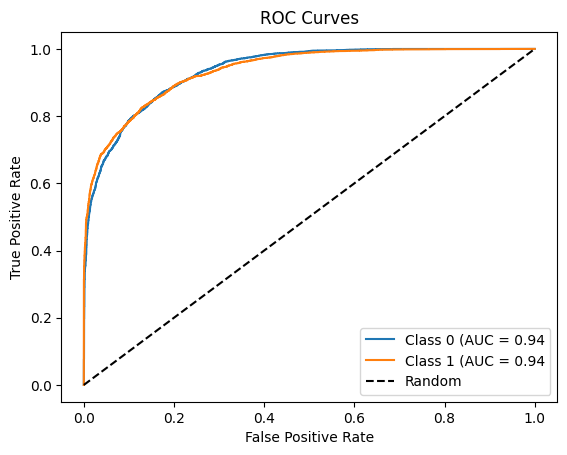

In [ ]:
# Karena data prediction berbentuk [0, 1] maka perlu proses loop dilakukan masing masing per class. Sehingga output plot akan memiliki 2 garis.

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_pred.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(y_pred.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()


Train Accuracy 0.9495249799728394, epoch:100

Train Accuracy 0.9489499732971191, epoch:98

Train Accuracy 0.9464050185966492, epoch:97

Train Accuracy 0.9459000276565552, epoch:99

Train Accuracy 0.9433499861717224, epoch:96


Validation Accuracy 0.8681249345728417, epoch:43

Validation Accuracy 0.8681249345728417, epoch:59

Validation Accuracy 0.8615248686183789, epoch:55

Validation Accuracy 0.8600000056768982, epoch:42

Validation Accuracy 0.8600000056768982, epoch:60



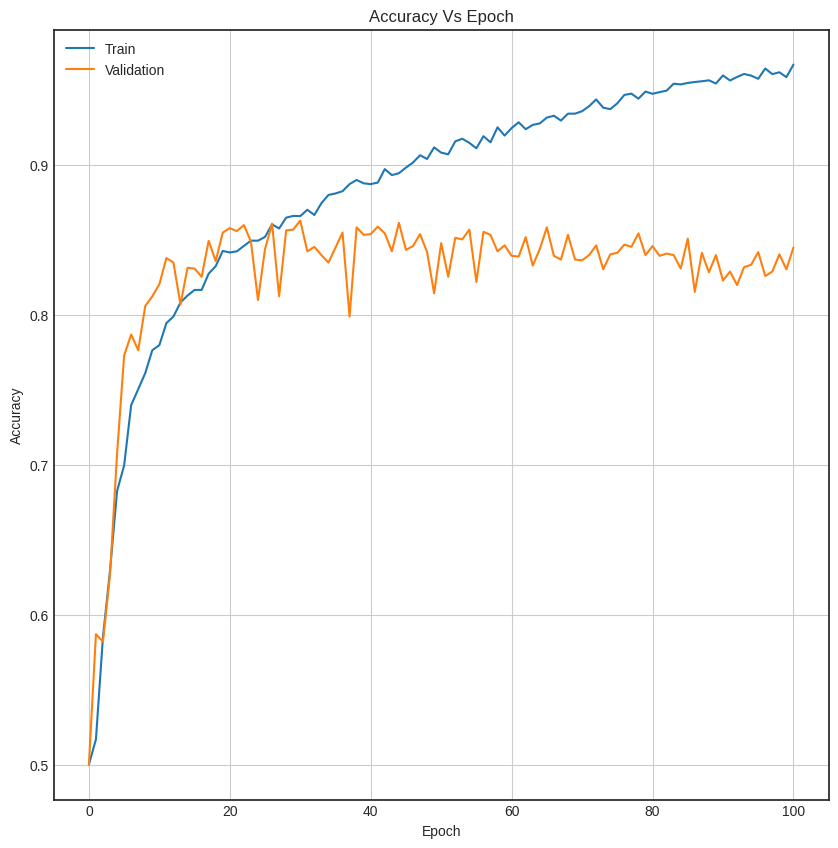

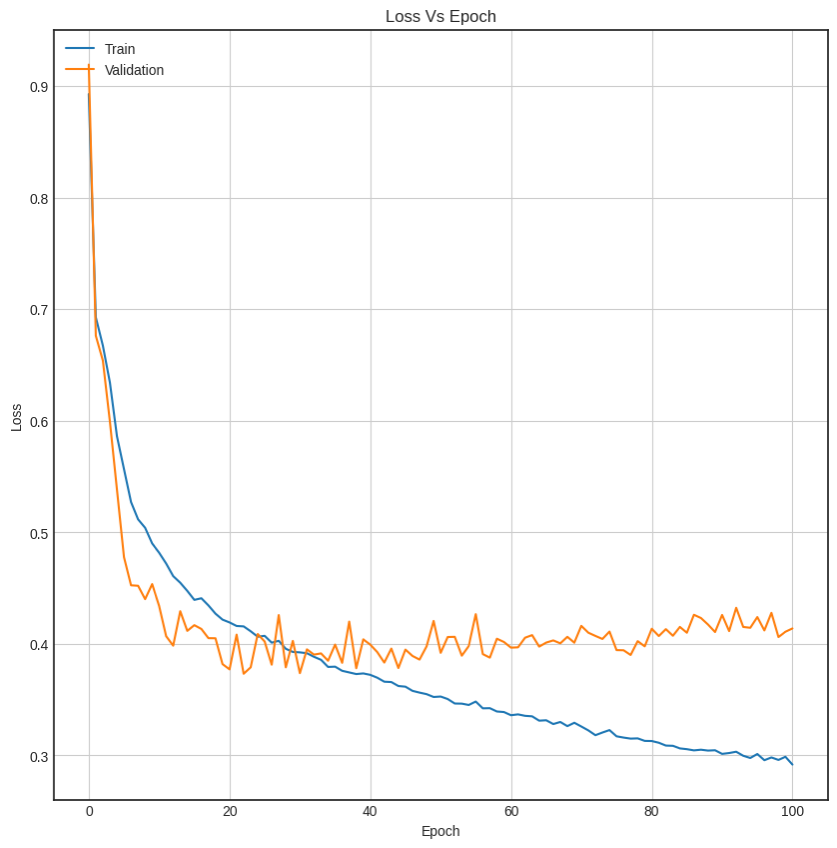

In [ ]:
# Menjalankan fungsi graphics yang sudah didefine pada cell atas, untuk mendapatkan epoch terbaik dan juga plot accuracy & loss.
AccTest = []
LossTest = []

graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)